## Generate prediction of different models

The variables that need to be modified are:

* name of model file
* number of epochs we want to evaluate (in case we have saved the model status at different epochs and we want to compare performance)
* architecture of the model. Needs to match the architecture of the model we are loading the parameters of 

#### Import libraries and external functions

Only for notebooks

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath('../'))

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import time
import healpy as hp
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors


import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.parameter import Parameter

from modules.utils import init_device
from modules.architectures import *
from modules.test import compute_rmse, compute_rmse_equiangular, create_iterative_observations_eq, compute_weighted_rmse
from modules.plotting import plot_rmses
from modules.full_pipeline import load_data_split, WeatherBenchDatasetXarrayHealpixTemp, \
                                  train_model_2steps, create_iterative_predictions_healpix_temp, \
                                  compute_errors, plot_climatology
from modules.plotting import plot_general_skills, plot_benchmark, plot_skillmaps, plot_benchmark_simple
from modules.data import hp_to_equiangular
from modules.mail import send_info_mail

from deepsphere.utils.samplings import equiangular_dimension_unpack
import warnings
warnings.filterwarnings("ignore")

In [3]:
model_path = '/nfs_home/wefeng/results/equiangular/models/'
model_name_epochs = 'all_const_len2_delta_6_architecture_loss_v0_8steps_constant_increasing_static_l3_long_connections_per_epoch'
#model_name = model_path + model_name_epochs + '_epoch_{}.h5'.format(num_epoch)

Define paths and create directories if required

In [4]:
datadir = "/nfs_home/wefeng/equiangular/"
input_dir = datadir + "5.625deg/"
model_save_path = '/nfs_home/wefeng/results/equiangular/models/'
result_path = '/nfs_home/wefeng/results/equiangular/'

prediction_path = '/nfs_home/wefeng/results/equiangular/predictions/'

if not os.path.isdir(model_save_path):
    os.mkdir(model_save_path)

Define constants and load data

In [5]:
chunk_size = 521

train_years = ('1990', '2012')#('1979', '2012')
val_years = ('2013', '2016')
test_years = ('2017', '2018')

nodes = 32 * 64
max_lead_time = 5*24
nb_timesteps = 2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
gpu = [0]
num_workers = 10
pin_memory = True

nb_epochs = 2
learning_rate = 8e-3

obs = xr.open_mfdataset(prediction_path + 'observations.nc', combine='by_coords', chunks={'time':chunk_size})
rmses_weyn = xr.open_dataset(datadir + 'metrics/rmses_weyn.nc')

#### Data

Load data, define dynamic dataset and separate into train, validation and test

In [6]:
ds_train, ds_valid, ds_test = load_data_split(input_dir, train_years, val_years, test_years, chunk_size)

/nfs_home/wefeng/equiangular/5.625deg/


In [7]:
constants = xr.open_dataset(f'{input_dir}constants/constants_5.625deg_standardized.nc')

orog = constants['orog']
lsm = constants['lsm']
lats = constants['lat2d']
slt = constants['slt']

num_constants = len([orog, lats, lsm, slt])

train_mean_ = xr.open_mfdataset(f'{input_dir}mean_train_features_dynamic.nc')
train_std_ = xr.open_mfdataset(f'{input_dir}std_train_features_dynamic.nc')

Define model parameters

In [8]:
len_sqce = 2
# define time resolution
delta_t = 6

# predict 5days data
max_lead_time = 5*24
in_features = 7
out_features = 2

Generate dataloader

#### Model

Define model, train and evaluate train and validation losses



In [9]:
batch_size = 70
epochs = 10

In [10]:
constants_tensor = torch.tensor(xr.merge([orog, lats, lsm, slt], compat='override').to_array().values, \
                            dtype=torch.float)

# standardize 
constants_tensor_mean = torch.mean(constants_tensor, dim=1, keepdim=True)
constants_tensor_std = torch.std(constants_tensor, dim=1, keepdim=True)
constants_tensor = (constants_tensor - constants_tensor_mean) / (constants_tensor_std + 1e-6)

#### Test 

Define test dataloader, generate predictions and evaluate loss

In [11]:
# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_test, out_features=out_features,
                                                  len_sqce=len_sqce, delta_t=delta_t, years=test_years, 
                                                  nodes=nodes, nb_timesteps=nb_timesteps, 
                                                  mean=train_mean_, std=train_std_, 
                                                  max_lead_time=max_lead_time)

Loading data to RAM...
Time: 1.67s


### THIS NEEDS TO BE MODIFIED ACCORDING TO THE CHOSEN ARCHITECTURE! 

In [12]:
#UNetSphericalHealpixResidualLongConnections

In [13]:
#UNetSphericalHealpixResidualShort3LevelsOnlyEncoder

In [14]:
def pix2ang():
    # deg = 5.625
    new_lon_idx = np.linspace(0, 354.375, num=32, endpoint=True)
    new_lat_idx = np.linspace(-87.1875, 87.1875, num=64, endpoint=True)

    new_lat_idx, new_lon_idx = np.meshgrid(new_lat_idx, new_lon_idx, indexing='ij')

    new_lon_idx = new_lon_idx.reshape(-1)
    new_lat_idx = new_lat_idx.reshape(-1)
    return new_lat_idx, new_lon_idx

Processing lead time 20 out of 20Z500 - 0: 141.9814866132305
T850 - 0: 1.1756792495954689


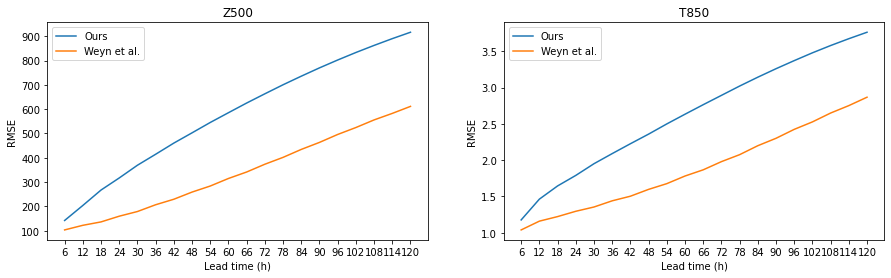

In [15]:
for ep in range(11, 12):
    model_name = model_path + model_name_epochs + '_epoch_{}.h5'.format(ep)
    #architecture_name = "debug_loading_model
    description = model_name_epochs + '_epoch_{}'.format(ep)

    pred_save_path = result_path + "predictions/" + model_name_epochs + '/'
    
    if not os.path.isdir(pred_save_path):
        os.mkdir(pred_save_path)

    model_filename = model_save_path + description + ".h5"
    pred_filename = pred_save_path +  description + ".nc"
    rmse_filename = result_path + 'metrics/rmse_' + description + '.nc'
    
    
    

    metrics_path = '/nfs_home/wefeng/results/equiangular/metrics/'
    figures_path = '/nfs_home/wefeng/results/equiangular/figures/' + description + '/'
    
    if not os.path.isdir(figures_path):
        os.mkdir(figures_path)

    # load model
    unpacked = equiangular_dimension_unpack(nodes, ratio=2)
    unpacked = np.array(unpacked) // 2
    spherical_unet_new2 = UNetSphericalEquiangularResidualLongConnections(N=unpacked, in_channels=in_features*len_sqce, out_channels=out_features, kernel_size=3)
    state_to_load = torch.load(model_name)
    
    own_state = spherical_unet_new2.state_dict()
    for name, param in state_to_load.items():
        if name not in own_state:
            if '.'.join(name.split('.')[1:]) not in own_state:
            #own_state[name] = param
                print(name)
            else:
                n = name
                name = '.'.join(n.split('.')[1:])
                
            #continue
        if isinstance(param, Parameter):
            # backwards compatibility for serialized parameters
            param = param.data
        own_state[name].copy_(param)
        
    spherical_unet_new2, device = init_device(spherical_unet_new2, gpu=gpu)
    
    # compute predictions
    predictions2, lead_times, times, nodes, out_lat, out_lon = \
    create_iterative_predictions_healpix_temp(spherical_unet_new2, \
                                              device, testing_ds, constants_tensor.transpose(1,0))
    # save predictions
    das = [];
    lev_idx = 0
    for var in ['z', 't']:       
        das.append(xr.DataArray(
            predictions2[:, :, :, lev_idx],
            dims=['lead_time', 'time', 'node'],
            coords={'lead_time': lead_times, 'time': times[:predictions2.shape[1]], 'node': np.arange(nodes)},
            name=var
        ))
        lev_idx += 1

    prediction_ds_new2 = xr.merge(das)
    out_lat, out_lon = pix2ang()
    prediction_ds_new2 = prediction_ds_new2.assign_coords({'lat': out_lat, 'lon': out_lon})
    
    prediction_ds_new2.to_netcdf(pred_filename)
    
    # load observations
#     obs = xr.open_mfdataset(prediction_path + 'observations.nc', combine='by_coords')
    obs_sel = obs.isel(time=slice(6,prediction_ds_new2.time.shape[0]+6))
    
    # compute RMSE
    rmse = compute_weighted_rmse(prediction_ds_new2, obs_sel)
    rmse.to_netcdf(rmse_filename)
    
    # plot RMSE
    print('Z500 - 0:', rmse.z.values[0])
    print('T850 - 0:', rmse.t.values[0])

    plot_rmses(rmse, rmses_weyn.rename({'z500':'z', 't850':'t'}).isel(lead_time=list(range(20))), lead_time=6)

    #del spherical_unet
    #del prediction_ds, rmse
    torch.cuda.empty_cache()

#### Generate plots for evaluation

In [ ]:
resolution = 5.625
lead_time = 6
start_time = len_sqce * lead_time - 6
end_time = (6-lead_time) if (6-lead_time) > 0 else None

# Data
lead_times = np.arange(lead_time, max_lead_time+lead_time, lead_time)

#obs = xr.open_mfdataset(prediction_path + 'observations_nearest.nc', combine='by_coords')
#pred = xr.open_mfdataset(prediction_path  + description + '.nc', combine='by_coords')
#obs = obs.isel(time=slice(6,pred.time.shape[0]+6))

Compute errors

In [ ]:
#obsc = xr.open_mfdataset(prediction_path + 'observations_nearest.nc', combine='by_coords', chunks={'time':chunk_size})
#predc = xr.open_mfdataset(prediction_path  + description + '.nc', combine='by_coords', chunks={'time':chunk_size})
#obsc = obsc.isel(time=slice(6,pred.time.shape[0]+6))

In [ ]:
t = time.time()
corr_map, rbias_map, rsd_map, rmse_map, obs_rmse, rmse_map_norm = compute_errors(prediction_ds_new2, obs)
print(time.time() - t)

In [ ]:
metrics_path + 'rmse_' + description + '.nc'

In [ ]:
rmse_spherical = xr.load_dataset(metrics_path + 'rmse_' + description + '.nc')
rbias_spherical = rbias_map.mean('node').compute()
rsd_spherical = rsd_map.mean('node').compute()
corr_spherical = corr_map.mean('node').compute()

In [ ]:
rbias_spherical.to_netcdf(metrics_path + 'rbias_' + description + '.nc')
rsd_spherical.to_netcdf(metrics_path + 'rsd_' + description + '.nc')
corr_spherical.to_netcdf(metrics_path + 'corr_' + description + '.nc')

In [ ]:
plot_benchmark_simple(rmse_spherical, description, lead_times, 
               input_dir=metrics_path, output_dir=figures_path, title=False)

In [ ]:
plot_general_skills(rmse_map_norm, corr_map, rbias_map, rsd_map, description, lead_times, 
                    output_dir=figures_path, title=False)

plot_skillmaps(rmse_map_norm, rsd_map, rbias_map, corr_map, description, lead_times, resolution, 
               output_dir=figures_path)

Climatology Hovmoller

In [ ]:
monthly_mean = prediction_ds_new2.groupby('time.month').mean().compute()
monthly_mean_obs = obs.groupby('time.month').mean().compute()

In [ ]:
lead_idx = 19

# Computations
monthly_mean.isel(lead_time=lead_idx)
monthly_mean_eq = []
for month in range(12):
    monthly_mean_eq.append(hp_to_equiangular(monthly_mean.isel(lead_time=lead_idx, month=month), 
                                     resolution))
monthly_mean_eq = xr.concat(monthly_mean_eq, pd.Index(np.arange(1, 13, 1), name='month'))
monthly_lat_eq = monthly_mean_eq.mean('lon')

monthly_mean_obs.isel(lead_time=lead_idx)
monthly_mean_eq_obs = []
for month in range(12):
    monthly_mean_eq_obs.append(hp_to_equiangular(monthly_mean_obs.isel(lead_time=lead_idx, month=month), 
                                     resolution))
monthly_mean_eq_obs = xr.concat(monthly_mean_eq_obs, pd.Index(np.arange(1, 13, 1), name='month'))
monthly_lat_eq_obs = monthly_mean_eq_obs.mean('lon')

pred_z = np.rot90(monthly_lat_eq.z.values, 3)
pred_t = np.rot90(monthly_lat_eq.t.values, 3)
obs_z = np.rot90(monthly_lat_eq_obs.z.values, 3)
obs_t = np.rot90(monthly_lat_eq_obs.t.values, 3)

diff_z = pred_z / obs_z
diff_t = pred_t / obs_t

# Labels and limits
ticks = np.linspace(0, 31, 7).astype(int)
lat_labels = np.linspace(-90, 90, 7).astype(int)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

vmin_z = min(np.min(monthly_lat_eq.z).values.flatten()[0], np.min(monthly_lat_eq_obs.z).values.flatten()[0])
vmax_z = max(np.max(monthly_lat_eq.z).values.flatten()[0], np.max(monthly_lat_eq_obs.z).values.flatten()[0])
vmin_t = min(np.min(monthly_lat_eq.t).values.flatten()[0], np.min(monthly_lat_eq_obs.t).values.flatten()[0])
vmax_t = max(np.max(monthly_lat_eq.t).values.flatten()[0], np.max(monthly_lat_eq_obs.t).values.flatten()[0])

delta = min((np.min(diff_z)-1), (1-np.max(diff_z)), (np.min(diff_t)-1), (1-np.max(diff_t)))

vmin_sd = 1 - delta
vmax_sd = 1 + delta

In [ ]:
predictions_vals = {'pred_z': pred_z, 'pred_t': pred_t,'obs_z': obs_z,'obs_t': obs_t}
val_limits = {'vmin_z':vmin_z, 'vmax_z':vmax_z, 'vmin_t':vmin_t, \
              'vmax_t':vmax_t, 'vmin_sd':vmin_sd, 'vmax_sd':vmax_sd}

In [ ]:
 
figname = figures_path + description + '_hovmoller'
plot_climatology(figname, predictions_vals, val_limits, ticks, lat_labels, month_labels)

In [ ]:
# import json

In [ ]:
# with open("../modules/confMail.json") as json_data_file:
#     mailConf = json.load(json_data_file)

# mail = {
#     "sender": mailConf["sender"],
#     "receiver": mailConf["sender"],
#     "subject": "Results generated!",
#     "body": "Results from model {}.\n Losses: \nZ500: t0 \t{}\t t120 \t{}\nt850: t0 \t{}\t t120 \t{} "\
#     .format(description, rmse_spherical.z[0].values, rmse_spherical.z[-1].values, rmse_spherical.t[0].values, rmse_spherical.t[-1].values),
#     "fileAttaching": "Yes",
#     "file": [figures_path + description + '_benchmark.png', \
#              figures_path + description + '_general_skills.png', \
#              figures_path + description + '_0_maps.png', figures_path + description + '_19_maps.png',]


# }
# send_info_mail(mailInfo=mail, configFile=mailConf)